#NASA Space Apps Challenge 2023 in Tashkent



### Team: Typhoon
### Members:
- Yaxshiliqov Javlon
- Jabborov Diyorbek

In [23]:
from tqdm import tqdm
import pandas as pd

import numpy as np
from concurrent.futures import ThreadPoolExecutor
from multiprocessing.pool import ThreadPool
import os

import matplotlib.pyplot as plt
from matplotlib import colors

def extract_kernel_df(image_arr: np.array, feature: str = "default", kernel: int = 3) -> pd.DataFrame:
    """
    Function which takes a 2d image array, applies a kernel
    to each pixel, and returns a dataframe where each row is the kernel for a single pixel
    and each col is a location on the kernel.
    """
    strided = np.lib.stride_tricks.sliding_window_view(image_arr, (kernel, kernel))
    strided_reshaped = strided.reshape(strided.shape[0]*strided.shape[1], kernel*kernel) # flatten the kernel and a row for each pixel
    columns = [f"{feature}_{i}" for i in range(kernel*kernel)]
    return pd.DataFrame(data = strided_reshaped, columns = columns)

Get features available from a single example

In [24]:
import os

directory_path = '/content/'
features = [f for f in os.listdir(directory_path) if f.endswith('.npy')]
features = [os.path.splitext(f)[0] for f in features if f != 'sea_surface_temperature.npy']
features

['elevation',
 'precipitation_amount_1hour_Accumulation',
 'tomorrows_frp',
 'air_temperature_at_2_metres_1hour_Minimum',
 'dew_point_temperature_at_2_metres',
 'eastward_wind_at_100_metres',
 'air_temperature_at_2_metres_1hour_Maximum',
 'northward_wind_at_10_metres',
 'eastward_wind_at_10_metres',
 'ndvi',
 'tomorrows_fires',
 'todays_fires',
 'surface_air_pressure',
 'air_pressure_at_mean_sea_level',
 'northward_wind_at_100_metres',
 'todays_frp',
 'lwe_thickness_of_surface_snow_amount',
 'snow_density',
 'landcover',
 'air_temperature_at_2_metres']

In [25]:
sample_ids = [0]

Samples are split into train/test/eval in a csv, for consistent comparison with the deep learning model.

Now loop to extract data from s3 to local dataframe

In [26]:

def get_data_for_sample(id: int) -> pd.DataFrame:
    feature_df_list = []
    for feature in features:
        img_arr = np.load(f'/content/{feature}.npy')
        if feature == 'tomorrows_fires':
            img_arr = img_arr[1:-1, 1:-1]
            feature_df = pd.DataFrame(data = img_arr.flatten(), columns = ['tomorrows_fires'])
        else:
            feature_df = extract_kernel_df(img_arr, feature)
        feature_df_list.append(feature_df)
    feature_df_list.append(pd.DataFrame(data = np.ones(62*62)*int(id), columns = ['image_index']))
    return pd.concat(feature_df_list, axis=1)

In [27]:
%%time

with ThreadPool(os.cpu_count()) as pool:
      results = list(tqdm(pool.imap(get_data_for_sample, sample_ids), total=len(sample_ids)))

len(results)

df = pd.concat(results, axis=0)
df.to_csv('data.csv', index=False)
df.shape

100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


CPU times: user 744 ms, sys: 17.9 ms, total: 762 ms
Wall time: 777 ms


(3844, 173)

static_fire_pixels: 19.0
fire_ave_size: 0.023413111342351717
percent static: 81151.1 %


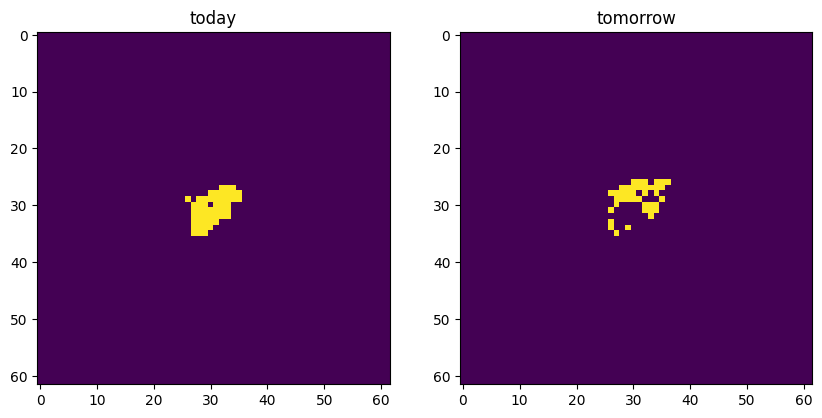

In [42]:
def plot_feature(image_index: int):
    frame_size = 62*62
    start_index = image_index * frame_size
    end_index = (image_index + 1) * frame_size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    today = df["todays_fires_4"].iloc[start_index:end_index].values.reshape(62, 62)
    tomorrow = df["tomorrows_fires"].iloc[start_index:end_index].values.reshape(62, 62)
    ax1.imshow(today)
    ax1.set_title("today")
    ax2.imshow(tomorrow)
    ax2.set_title("tomorrow")
    static_fire_pixels = np.sum(today.flatten() * tomorrow.flatten())
    print(f"static_fire_pixels: {static_fire_pixels}")
    fire_ave_size = np.mean(today.flatten() + tomorrow.flatten())
    print(f"fire_ave_size: {fire_ave_size}")
    print(f"percent static: {round(100 * static_fire_pixels / fire_ave_size, 1)} %")

image_index = 0
plot_feature(image_index)
